In [1]:
# # 20220517 5组 光阱中同球的实验组 移动到数据集16位图 光镊捕获的球数据增广做训练组 光镊捕获的球做测试组 步进30nm cut3
# #  经过数据增广的图片分门别类 训练集和验证集 4：1
# import os,shutil,glob
# import numpy as np
# path_from = os.path.abspath(r'E:\gmd_data\2022年05月17日\5\16cut3_test_Augument')	#图片原来位置的位置
# path_target = os.path.abspath(r'E:\gmd_data\2022_05_17_05_TrapSingle_step30_Augumented\train')	#图片移动到的位置
# path_target2 = os.path.abspath(r'E:\gmd_data\2022_05_17_05_TrapSingle_step30_Augumented\valid')	#图片移动到的位置
# for i in range(7000,12000,48): #这里创建626个文件夹 步进48：30nm
#     # *定义一个变量判断文件是否存在,path指代路径,str(i)指代文件夹的名字*
#     isExists = os.path.exists(path_target+"\\"+str(i))
#     if not isExists:						# 判断如果文件不存在,则创建
#         os.makedirs(path_target+"\\"+str(i))       # 创建文件夹
#     isExists = os.path.exists(path_target2+"\\"+str(i))
#     if not isExists:						# 判断如果文件不存在,则创建
#         os.makedirs(path_target2+"\\"+str(i))       # 创建文件夹

#     fns = glob.glob(path_from+'\\'+str(i)+'_'+'*.png') # 每一个高度的图片 读取一次
#     # print(fns)
#     for ind in range(len(fns)): # 列表中的每一张图循环一次
#         dir,fn = os.path.split(fns[ind])  # 分离路径和文件名
#         if ind < len(fns)*0.8:
#             dstfn = path_target+'\\'+str(i)+'\\'+fn  # 生成目标目录下的新文件名
#             shutil.copy(fns[ind],dstfn) 
#             # print('ok',dstfn)
#         else:
#             dstfn = path_target2+'\\'+str(i)+'\\'+fn  # 生成目标目录下的新文件名
#             shutil.copy(fns[ind],dstfn) 
#             # print('ok',dstfn)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
image_transforms  = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        # transforms.RandomRotation(degrees = 45),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# dataset = 'E:\gmd_data\microsphere2_dataAugmented'
dataset = 'E:\gmd_data\\2022_05_17_05_TrapSingle_step30_Augumented'
train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

batch_size = 32
# num_classes = 173

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])

}


train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)

print(train_data_size, valid_data_size)

101640 25410


迁移学习
---------


这里使用ResNet-50的预训练模型。


In [6]:
resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = True

fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs,  105),
    nn.LogSoftmax(dim = 1)


)
resnet50 = resnet50.to('cuda:0')
loss_func = nn.NLLLoss()
# optimizer = optim.AdamW(resnet50.parameters(),lr=1e-4)

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



Epoch: 1/3000
Epoch: 001, Training: Loss: 3.9364, Accuracy: 5.6848%, 
		Validation: Loss: 3.7206, Accuracy: 13.6167%, Time: 4490.2383s
Best Accuracy for validation : 0.1362 at epoch 001


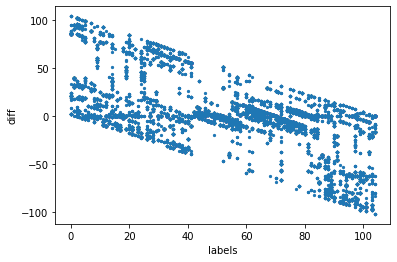

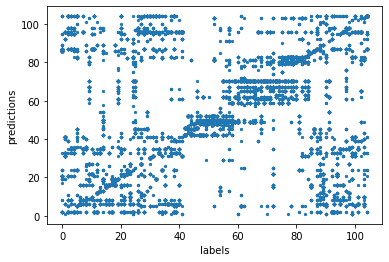

Epoch: 2/3000
Epoch: 002, Training: Loss: 2.3387, Accuracy: 26.3381%, 
		Validation: Loss: 3.6870, Accuracy: 32.5384%, Time: 4388.0729s
Best Accuracy for validation : 0.3254 at epoch 002


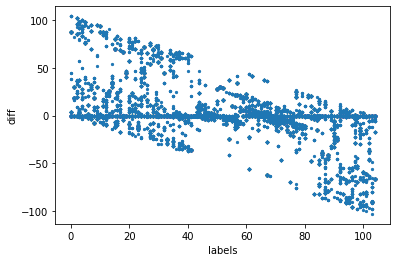

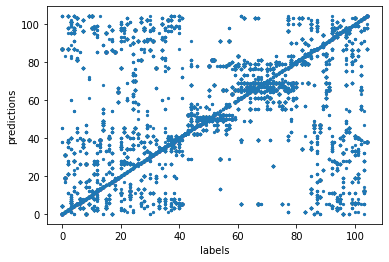

Epoch: 3/3000
Epoch: 003, Training: Loss: 1.4456, Accuracy: 49.8268%, 
		Validation: Loss: 3.8666, Accuracy: 47.2098%, Time: 4453.8551s
Best Accuracy for validation : 0.4721 at epoch 003


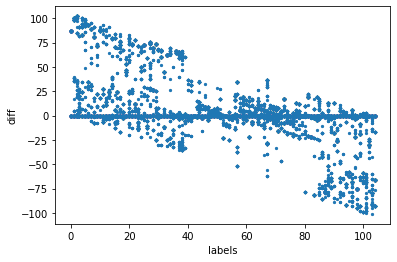

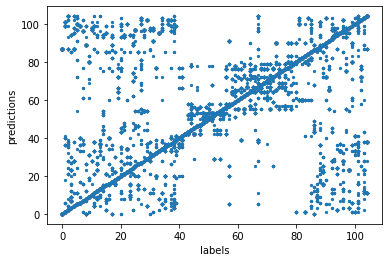

Epoch: 4/3000
Epoch: 004, Training: Loss: 0.9540, Accuracy: 66.9313%, 
		Validation: Loss: 4.2485, Accuracy: 47.9181%, Time: 4450.9676s
Best Accuracy for validation : 0.4792 at epoch 004


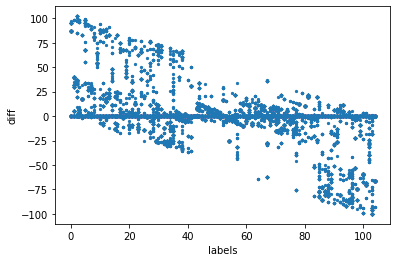

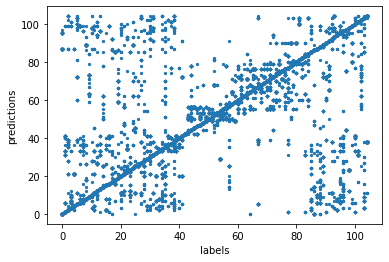

Epoch: 5/3000
Epoch: 005, Training: Loss: 0.6711, Accuracy: 77.1665%, 
		Validation: Loss: 4.6535, Accuracy: 50.3581%, Time: 4284.8804s
Best Accuracy for validation : 0.5036 at epoch 005


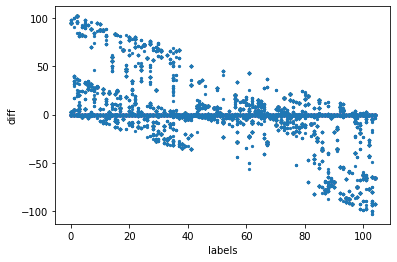

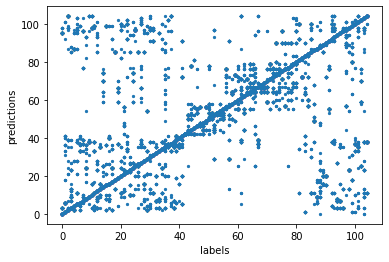

Epoch: 6/3000
Epoch: 006, Training: Loss: 0.5097, Accuracy: 83.0028%, 
		Validation: Loss: 5.0965, Accuracy: 50.4172%, Time: 4311.7557s
Best Accuracy for validation : 0.5042 at epoch 006


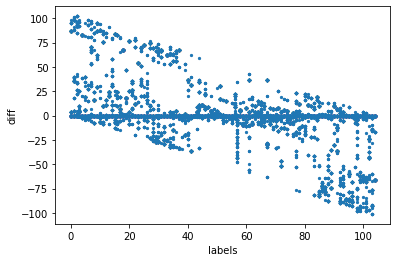

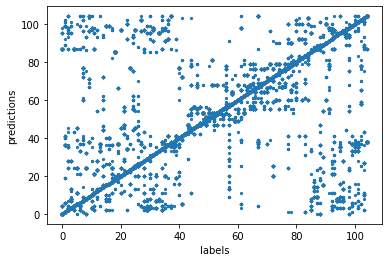

Epoch: 7/3000
Epoch: 007, Training: Loss: 0.3657, Accuracy: 87.8414%, 
		Validation: Loss: 4.9699, Accuracy: 50.8933%, Time: 4636.3671s
Best Accuracy for validation : 0.5089 at epoch 007


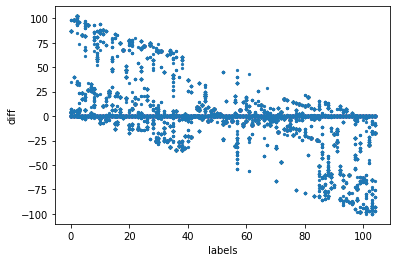

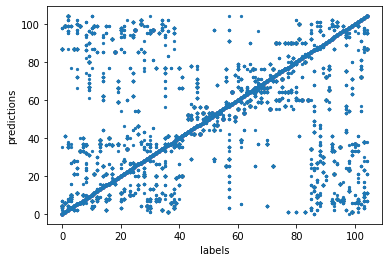

Epoch: 8/3000
Epoch: 008, Training: Loss: 0.3212, Accuracy: 89.3910%, 
		Validation: Loss: 5.1148, Accuracy: 51.6372%, Time: 3793.9091s
Best Accuracy for validation : 0.5164 at epoch 008


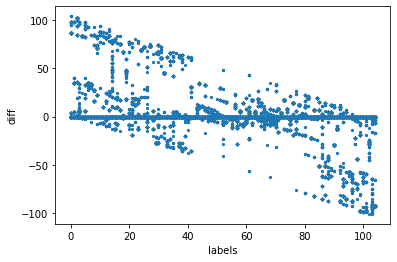

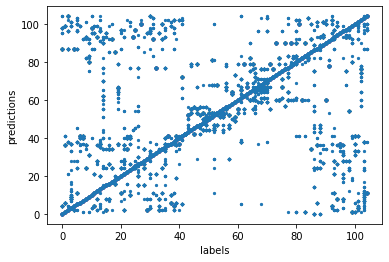

Epoch: 9/3000
Epoch: 009, Training: Loss: 0.2865, Accuracy: 90.5913%, 
		Validation: Loss: 5.3898, Accuracy: 51.9126%, Time: 3574.2476s
Best Accuracy for validation : 0.5191 at epoch 009


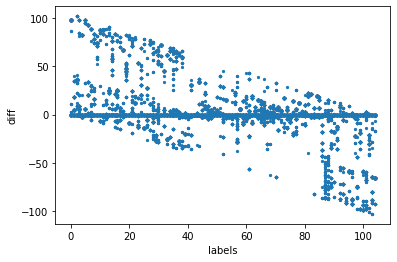

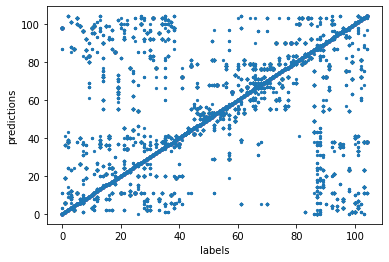

Epoch: 10/3000
Epoch: 010, Training: Loss: 0.2591, Accuracy: 91.5014%, 
		Validation: Loss: 5.3910, Accuracy: 51.4010%, Time: 3634.0654s
Best Accuracy for validation : 0.5191 at epoch 009


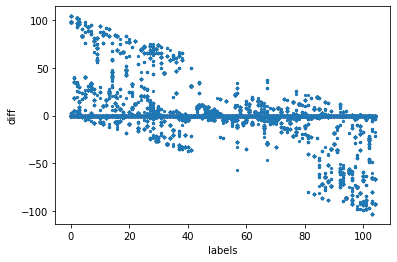

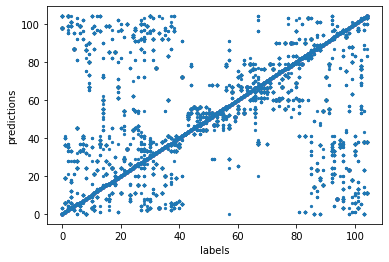

Epoch: 11/3000
Epoch: 011, Training: Loss: 0.2377, Accuracy: 92.1802%, 
		Validation: Loss: 5.6644, Accuracy: 51.8772%, Time: 3461.2871s
Best Accuracy for validation : 0.5191 at epoch 009


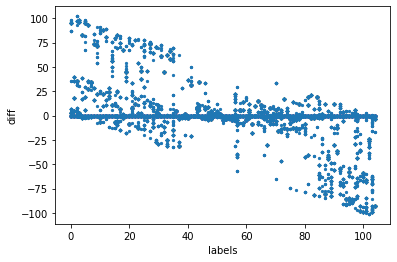

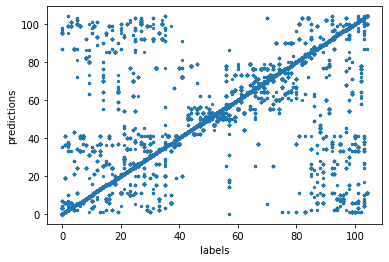

Epoch: 12/3000
Epoch: 012, Training: Loss: 0.2021, Accuracy: 93.3894%, 
		Validation: Loss: 5.5972, Accuracy: 51.5466%, Time: 3593.8917s
Best Accuracy for validation : 0.5191 at epoch 009


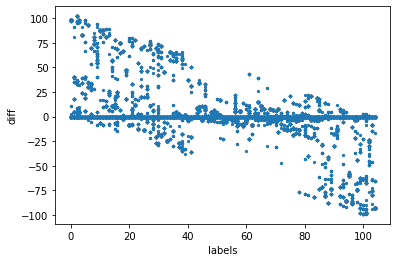

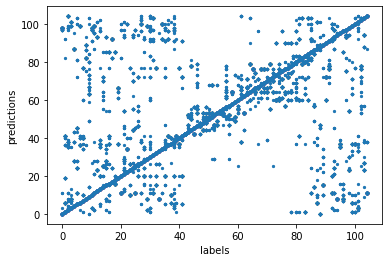

Epoch: 13/3000
Epoch: 013, Training: Loss: 0.1922, Accuracy: 93.6915%, 
		Validation: Loss: 5.5155, Accuracy: 52.0346%, Time: 3639.3816s
Best Accuracy for validation : 0.5203 at epoch 013


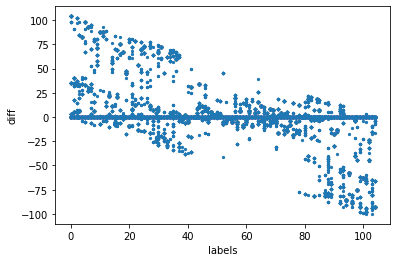

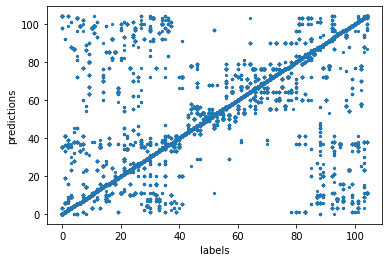

Epoch: 14/3000
Epoch: 014, Training: Loss: 0.1833, Accuracy: 94.0142%, 
		Validation: Loss: 5.7653, Accuracy: 51.6765%, Time: 3555.2127s
Best Accuracy for validation : 0.5203 at epoch 013


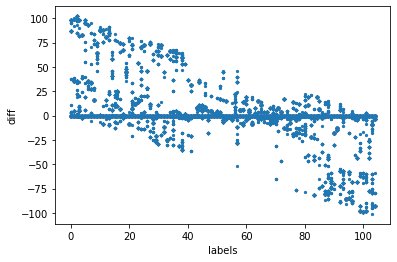

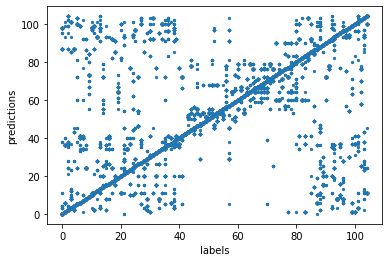

Epoch: 15/3000
Epoch: 015, Training: Loss: 0.1736, Accuracy: 94.3467%, 
		Validation: Loss: 6.1045, Accuracy: 51.5978%, Time: 3423.2275s
Best Accuracy for validation : 0.5203 at epoch 013


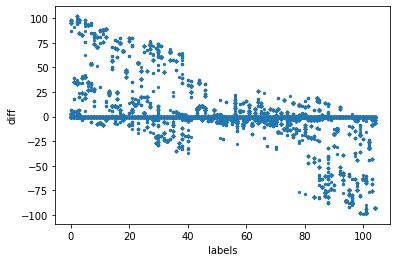

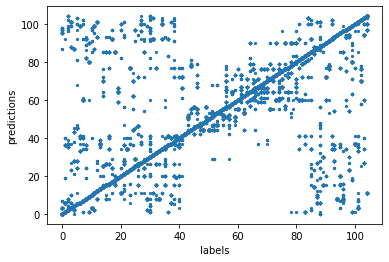

Epoch: 16/3000
Epoch: 016, Training: Loss: 0.1702, Accuracy: 94.4205%, 
		Validation: Loss: 5.7820, Accuracy: 51.8339%, Time: 3500.8887s
Best Accuracy for validation : 0.5203 at epoch 013


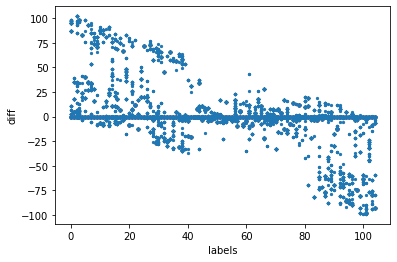

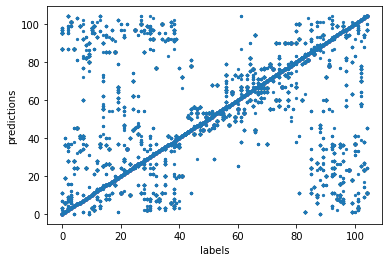

Epoch: 17/3000
Epoch: 017, Training: Loss: 0.1551, Accuracy: 94.9538%, 
		Validation: Loss: 5.7571, Accuracy: 52.5344%, Time: 3395.9064s
Best Accuracy for validation : 0.5253 at epoch 017


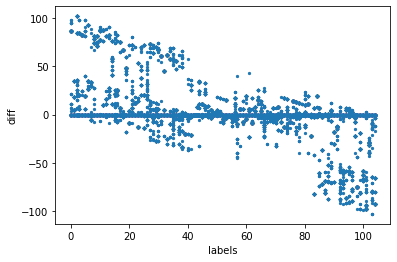

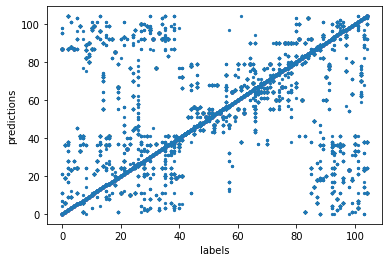

Epoch: 18/3000
Epoch: 018, Training: Loss: 0.1502, Accuracy: 95.0797%, 
		Validation: Loss: 5.6523, Accuracy: 51.6057%, Time: 3432.4797s
Best Accuracy for validation : 0.5253 at epoch 017


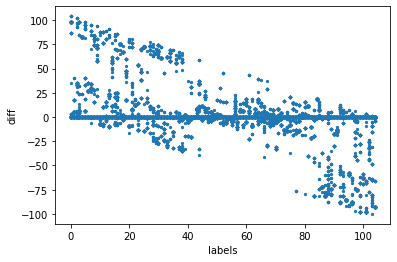

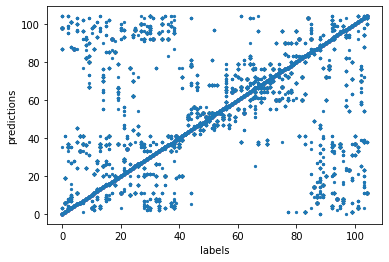

Epoch: 19/3000
Epoch: 019, Training: Loss: 0.1469, Accuracy: 95.2322%, 
		Validation: Loss: 5.8104, Accuracy: 51.8654%, Time: 3533.4917s
Best Accuracy for validation : 0.5253 at epoch 017


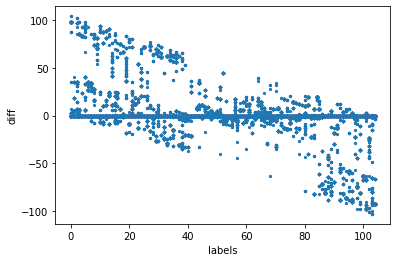

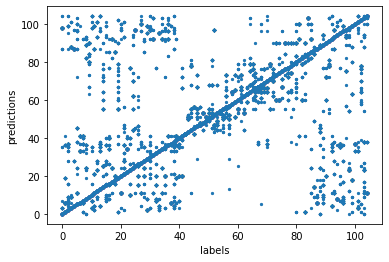

Epoch: 20/3000
Epoch: 020, Training: Loss: 0.1440, Accuracy: 95.3207%, 
		Validation: Loss: 5.8078, Accuracy: 51.7946%, Time: 3513.5275s
Best Accuracy for validation : 0.5253 at epoch 017


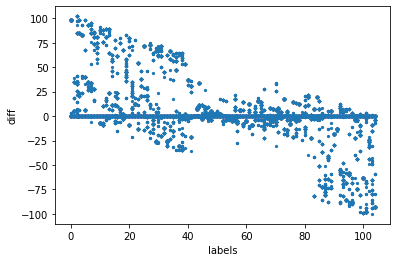

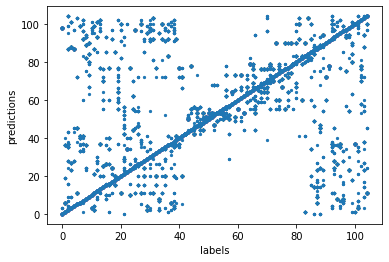

Epoch: 21/3000
Epoch: 021, Training: Loss: 0.1424, Accuracy: 95.3434%, 
		Validation: Loss: 5.7865, Accuracy: 51.9874%, Time: 3523.3330s
Best Accuracy for validation : 0.5253 at epoch 017


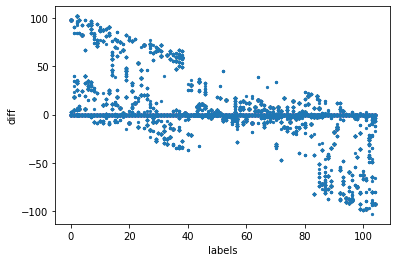

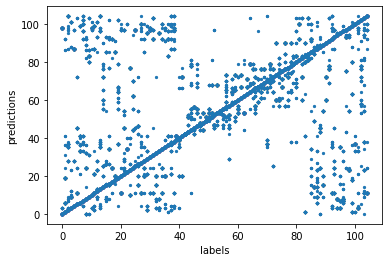

Epoch: 22/3000
Epoch: 022, Training: Loss: 0.1327, Accuracy: 95.6808%, 
		Validation: Loss: 5.8353, Accuracy: 51.6490%, Time: 3521.7707s
Best Accuracy for validation : 0.5253 at epoch 017


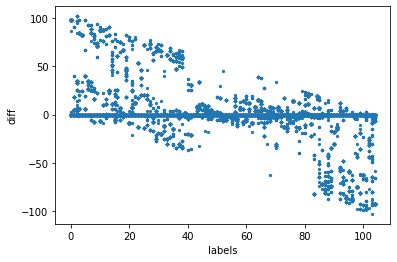

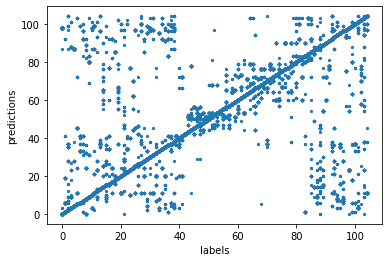

Epoch: 23/3000
Epoch: 023, Training: Loss: 0.1325, Accuracy: 95.6218%, 
		Validation: Loss: 5.9608, Accuracy: 51.5152%, Time: 4468.7703s
Best Accuracy for validation : 0.5253 at epoch 017


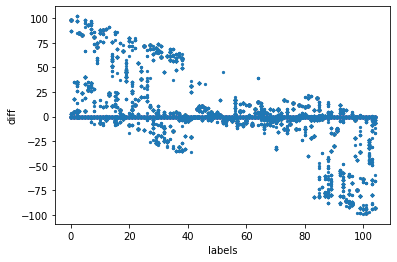

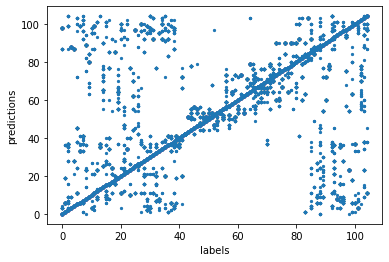

Epoch: 24/3000
Epoch: 024, Training: Loss: 0.1289, Accuracy: 95.7930%, 
		Validation: Loss: 5.8873, Accuracy: 51.5742%, Time: 4664.3448s
Best Accuracy for validation : 0.5253 at epoch 017


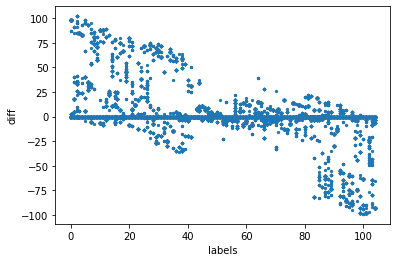

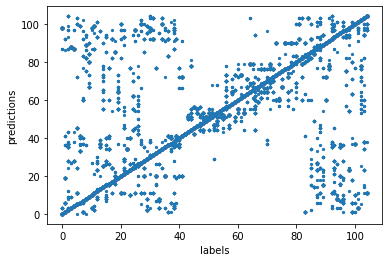

Epoch: 25/3000
Epoch: 025, Training: Loss: 0.1330, Accuracy: 95.6277%, 
		Validation: Loss: 6.0672, Accuracy: 51.3853%, Time: 4536.5391s
Best Accuracy for validation : 0.5253 at epoch 017


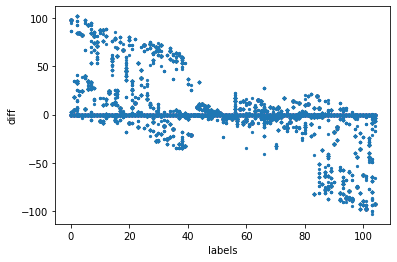

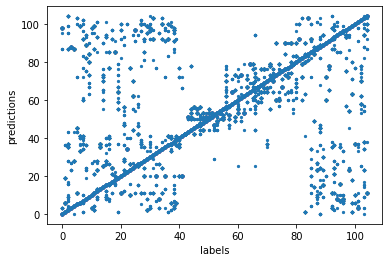

Epoch: 26/3000
Epoch: 026, Training: Loss: 0.1291, Accuracy: 95.6808%, 
		Validation: Loss: 5.9319, Accuracy: 51.6608%, Time: 4487.5689s
Best Accuracy for validation : 0.5253 at epoch 017


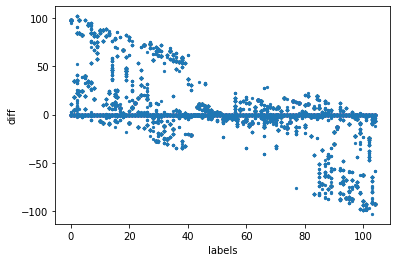

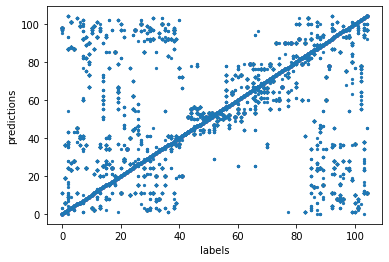

Epoch: 27/3000
Epoch: 027, Training: Loss: 0.1264, Accuracy: 95.8481%, 
		Validation: Loss: 5.8688, Accuracy: 51.7946%, Time: 4634.9533s
Best Accuracy for validation : 0.5253 at epoch 017


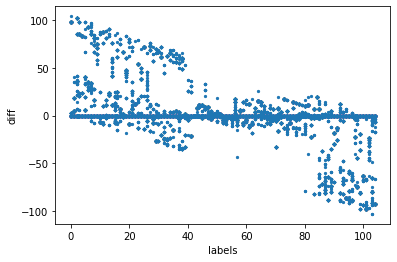

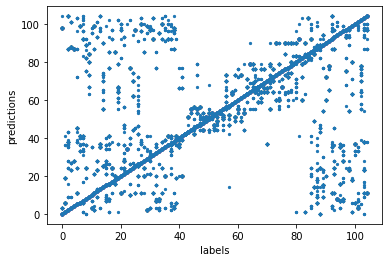

Epoch: 28/3000
Epoch: 028, Training: Loss: 0.1261, Accuracy: 95.8560%, 
		Validation: Loss: 6.0393, Accuracy: 51.9008%, Time: 3808.1691s
Best Accuracy for validation : 0.5253 at epoch 017


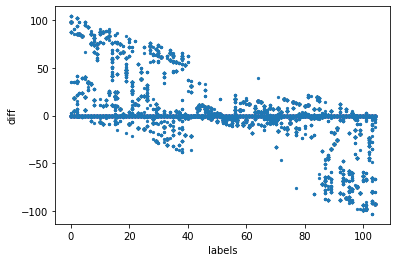

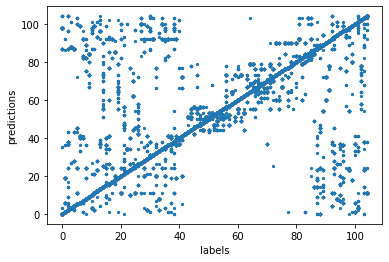

Epoch: 29/3000
Epoch: 029, Training: Loss: 0.1266, Accuracy: 95.8343%, 
		Validation: Loss: 5.9040, Accuracy: 51.7395%, Time: 3323.8181s
Best Accuracy for validation : 0.5253 at epoch 017


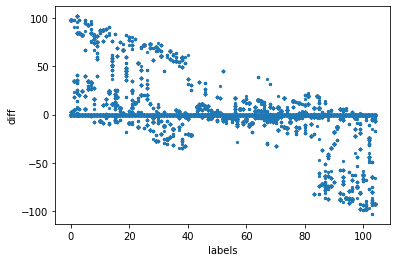

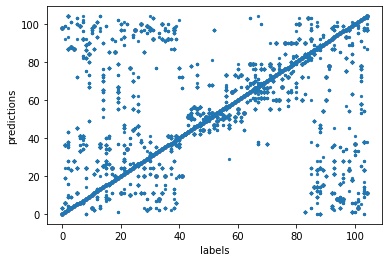

Epoch: 30/3000
Epoch: 030, Training: Loss: 0.1226, Accuracy: 95.9740%, 
		Validation: Loss: 5.9933, Accuracy: 51.9520%, Time: 3422.5137s
Best Accuracy for validation : 0.5253 at epoch 017


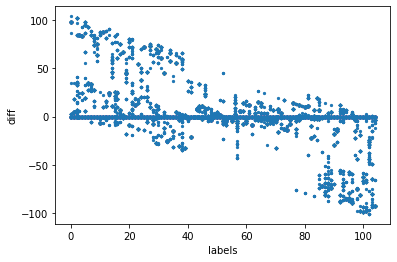

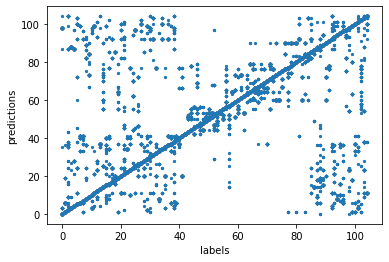

Epoch: 31/3000
Epoch: 031, Training: Loss: 0.1212, Accuracy: 96.0134%, 
		Validation: Loss: 5.8473, Accuracy: 51.5152%, Time: 3362.4798s
Best Accuracy for validation : 0.5253 at epoch 017


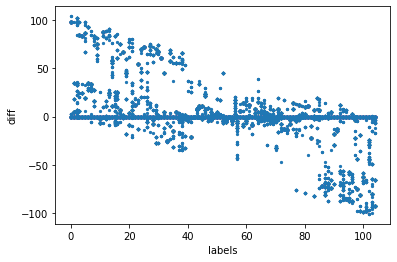

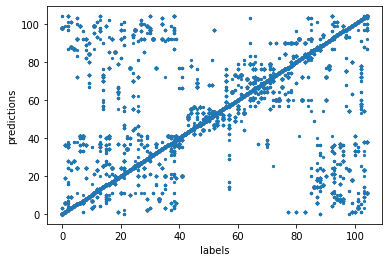

Epoch: 32/3000
Epoch: 032, Training: Loss: 0.1263, Accuracy: 95.8550%, 
		Validation: Loss: 5.9756, Accuracy: 51.5584%, Time: 3503.1524s
Best Accuracy for validation : 0.5253 at epoch 017


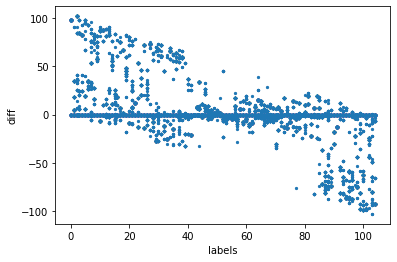

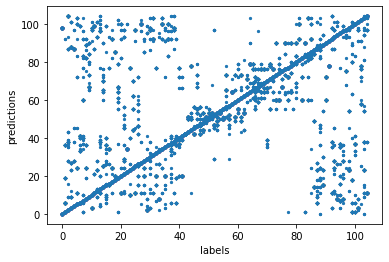

Epoch: 33/3000
Epoch: 033, Training: Loss: 0.1205, Accuracy: 96.0439%, 
		Validation: Loss: 5.9747, Accuracy: 51.4561%, Time: 3432.6009s
Best Accuracy for validation : 0.5253 at epoch 017


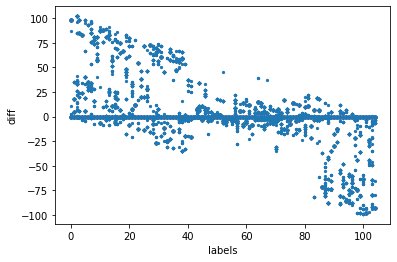

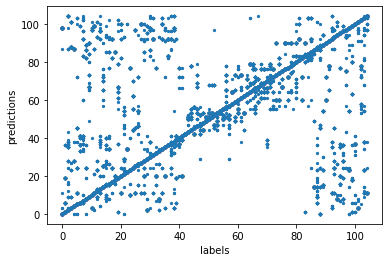

Epoch: 34/3000
Epoch: 034, Training: Loss: 0.1207, Accuracy: 96.0094%, 
		Validation: Loss: 6.0500, Accuracy: 51.3735%, Time: 3374.7107s
Best Accuracy for validation : 0.5253 at epoch 017


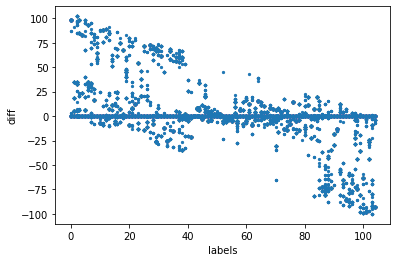

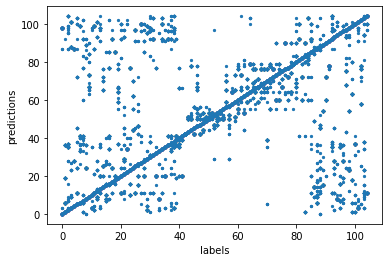

Epoch: 35/3000
Epoch: 035, Training: Loss: 0.1189, Accuracy: 96.1049%, 
		Validation: Loss: 6.1578, Accuracy: 51.1806%, Time: 3466.7284s
Best Accuracy for validation : 0.5253 at epoch 017


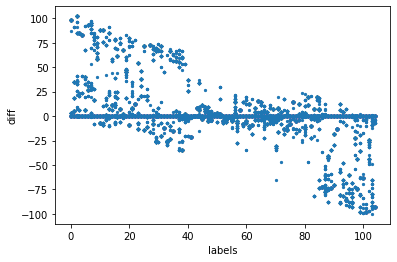

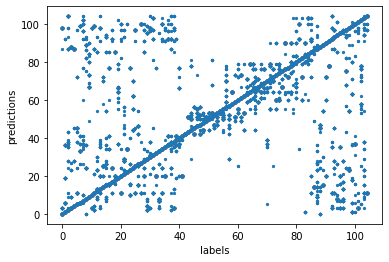

Epoch: 36/3000
Epoch: 036, Training: Loss: 0.1207, Accuracy: 96.0006%, 
		Validation: Loss: 6.0940, Accuracy: 51.5466%, Time: 3440.4341s
Best Accuracy for validation : 0.5253 at epoch 017


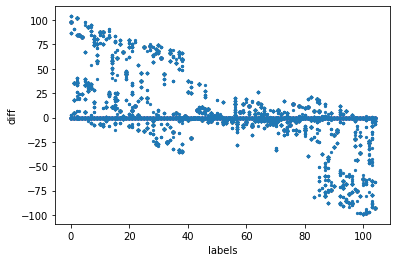

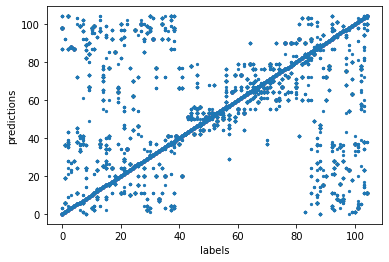

Epoch: 37/3000
Epoch: 037, Training: Loss: 0.1166, Accuracy: 96.1787%, 
		Validation: Loss: 5.8434, Accuracy: 51.8575%, Time: 3471.7429s
Best Accuracy for validation : 0.5253 at epoch 017


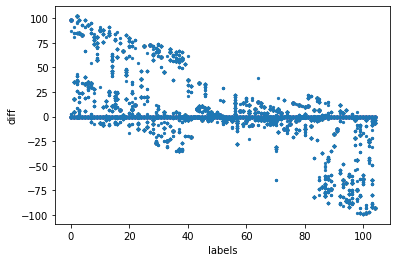

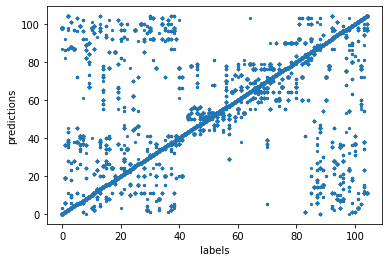

Epoch: 38/3000
Epoch: 038, Training: Loss: 0.1174, Accuracy: 96.2338%, 
		Validation: Loss: 5.9070, Accuracy: 51.5663%, Time: 3366.7569s
Best Accuracy for validation : 0.5253 at epoch 017


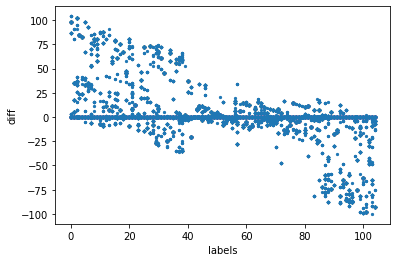

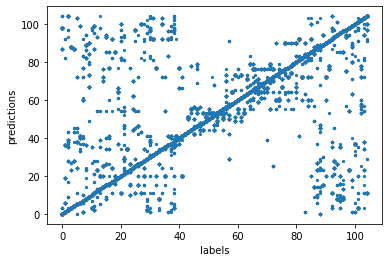

Epoch: 39/3000
Epoch: 039, Training: Loss: 0.1166, Accuracy: 96.1974%, 
		Validation: Loss: 5.8304, Accuracy: 51.7985%, Time: 3380.4751s
Best Accuracy for validation : 0.5253 at epoch 017


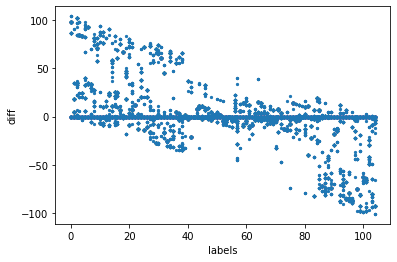

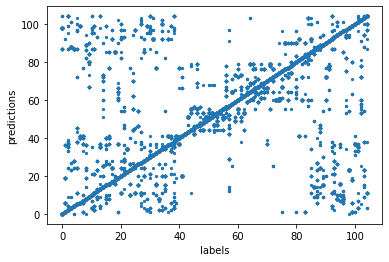

Epoch: 40/3000
Epoch: 040, Training: Loss: 0.1143, Accuracy: 96.2328%, 
		Validation: Loss: 5.8408, Accuracy: 51.5663%, Time: 3546.6565s
Best Accuracy for validation : 0.5253 at epoch 017


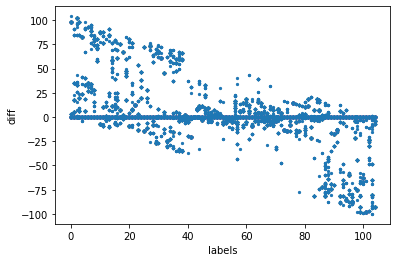

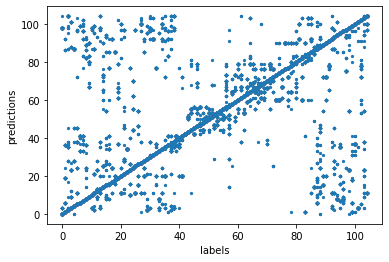

Epoch: 41/3000
Epoch: 041, Training: Loss: 0.1125, Accuracy: 96.3449%, 
		Validation: Loss: 5.9443, Accuracy: 51.9087%, Time: 3527.1412s
Best Accuracy for validation : 0.5253 at epoch 017


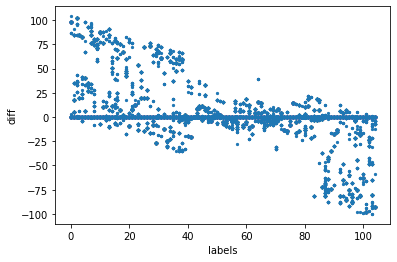

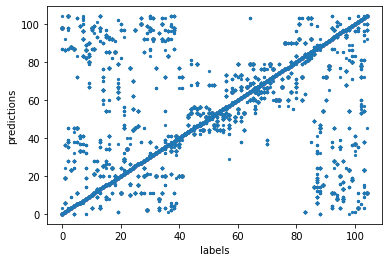

Epoch: 42/3000
Epoch: 042, Training: Loss: 0.1104, Accuracy: 96.3735%, 
		Validation: Loss: 5.7999, Accuracy: 51.6096%, Time: 3392.7858s
Best Accuracy for validation : 0.5253 at epoch 017


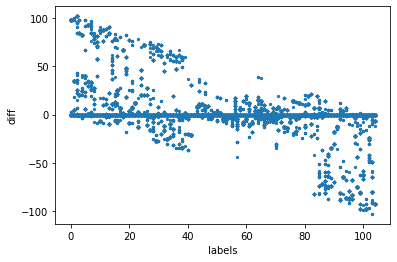

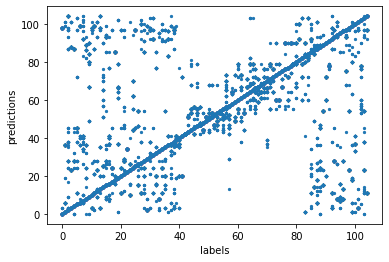

Epoch: 43/3000
Epoch: 043, Training: Loss: 0.1127, Accuracy: 96.3154%, 
		Validation: Loss: 5.8473, Accuracy: 51.6057%, Time: 3339.1740s
Best Accuracy for validation : 0.5253 at epoch 017


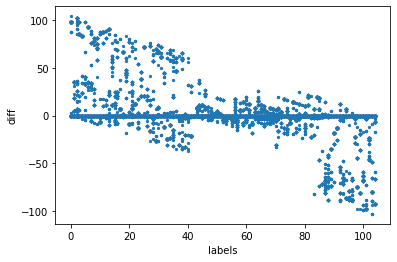

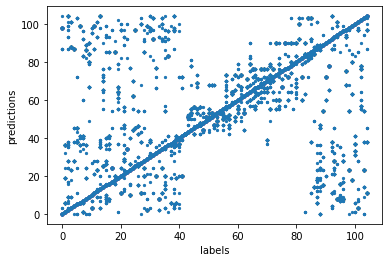

Epoch: 44/3000
Epoch: 044, Training: Loss: 0.1100, Accuracy: 96.3646%, 
		Validation: Loss: 5.9935, Accuracy: 51.4482%, Time: 3541.7261s
Best Accuracy for validation : 0.5253 at epoch 017


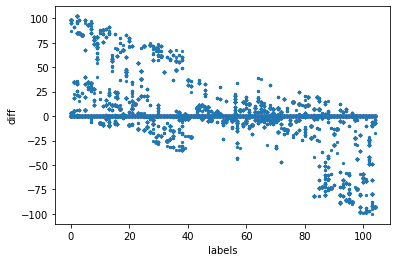

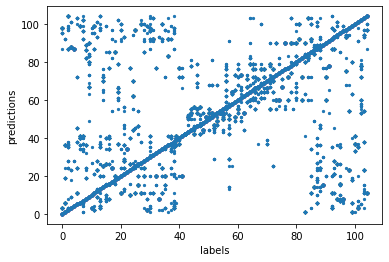

Epoch: 45/3000
Epoch: 045, Training: Loss: 0.1126, Accuracy: 96.3371%, 
		Validation: Loss: 6.0775, Accuracy: 51.4955%, Time: 3391.5285s
Best Accuracy for validation : 0.5253 at epoch 017


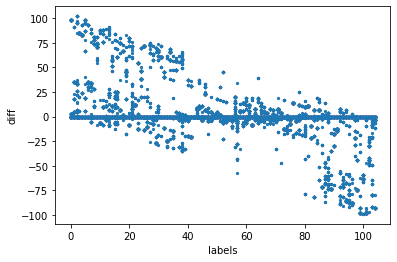

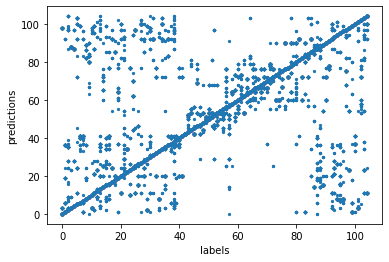

Epoch: 46/3000


: 

: 

In [ ]:
model = resnet50
loss_function = loss_func
epochs = 3000
# LR_value = 1e-4
LR_value = 1e-4
# trained_model, history = train_and_valid(resnet50, loss_func, num_epochs)
# torch.save(history, 'models/'+dataset+'_history.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
history = []
best_acc = 0.0
best_epoch = 0

for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    model.train()

    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
#         学习率递减
    if epoch <= 5:
        LR = LR_value;
    elif epoch <= 10:
        LR = LR_value*0.5;
    elif epoch <= 15:
        LR = LR_value*0.5*0.5;
    elif epoch <= 20:
        LR = LR_value*0.5*0.5*0.5;
    else:
        LR = LR_value*0.5*0.5*0.5*0.5;
    optimizer = optim.AdamW(resnet50.parameters(),lr=LR)

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.to(device)

        #因为这里梯度是累加的，所以每次记得清零
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_function(outputs, labels)

        loss.backward()

        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        train_acc += acc.item() * inputs.size(0)

    with torch.no_grad():
        model.eval()
        predictions_all = torch.tensor([]).to(device)
        labels_all = torch.tensor([]).to(device)

        for j, (inputs, labels) in enumerate(valid_data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = loss_function(outputs, labels)

            valid_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            predictions_all = torch.cat((predictions_all,predictions),dim=0)
            labels_all = torch.cat((labels_all,labels),dim=0)

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            valid_acc += acc.item() * inputs.size(0)

    avg_train_loss = train_loss/train_data_size
    avg_train_acc = train_acc/train_data_size

    avg_valid_loss = valid_loss/valid_data_size
    avg_valid_acc = valid_acc/valid_data_size

    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

    if best_acc < avg_valid_acc:
        best_acc = avg_valid_acc
        best_epoch = epoch + 1

    epoch_end = time.time()

    print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
        epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
    ))
    print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))

    torch.save(model, dataset+'/models/'+'model_'+str(epoch+1)+'.pt')

    diff = predictions_all - labels_all
    conc_all = torch.cat((labels_all,predictions_all,diff),dim=0)

    plt.scatter(labels_all.cpu(),diff.cpu(),s=5)
    # plt.legend(['Tr Accuracy', 'Val Accuracy'])
    plt.xlabel('labels')
    plt.ylabel('diff')
    # plt.ylim(0, 1)
    # plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
    plt.show()

    plt.scatter(labels_all.cpu(),predictions_all.cpu(),s=5)
    # plt.legend(['Tr Accuracy', 'Val Accuracy'])
    plt.xlabel('labels')
    plt.ylabel('predictions')
    # plt.ylim(0, 1)
    # plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
    plt.show()


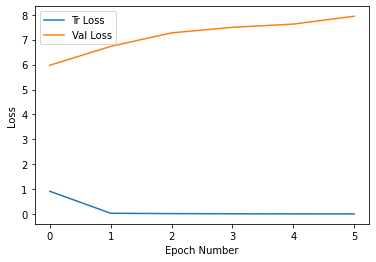

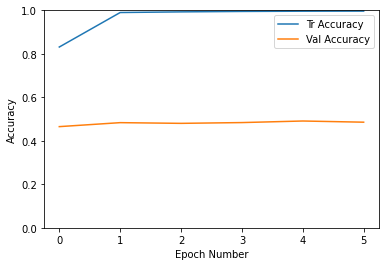

In [ ]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
# plt.ylim(0, 1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

plt.plot(history[:, 2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

导入模型 将验证集和真值对比图画出来
-------

In [ ]:
# 导入模型 将验证集和真值对比图画出来
dataset = 'E:\gmd_data\\2022_05_17_05_TrapSingle_Augument'
model38 = torch.load( dataset+'/models/'+'model_5.pt')
for param in model38.parameters():
    param.requires_grad = False
model38 = model38.to('cuda:0')
loss_function = nn.NLLLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
history = []
best_acc = 0.0
best_epoch = 0

valid_loss = 0.0
valid_acc = 0.0

predictions_all = torch.tensor([]).to(device)
labels_all = torch.tensor([]).to(device)
model38.eval()
for j, (inputs, labels) in enumerate(valid_data):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model38(inputs)

    loss = loss_function(outputs, labels)
    # print("valid_data_j: {}".format(j))
    # print("Outputs : ")
    # print(outputs)
    # print("labels ：")
    # print(labels)
    # print("loss ：")
    # print(loss)

    valid_loss += loss.item() * inputs.size(0)

    ret, predictions = torch.max(outputs.data, 1)

    predictions_all = torch.cat((predictions_all,predictions),dim=0)
    labels_all = torch.cat((labels_all,labels),dim=0)

    correct_counts = predictions.eq(labels.data.view_as(predictions))

    acc = torch.mean(correct_counts.type(torch.FloatTensor))

    valid_acc += acc.item() * inputs.size(0)

avg_valid_loss = valid_loss/valid_data_size
avg_valid_acc = valid_acc/valid_data_size

验证集 结果：准确率、误差图像
-

Validation: Loss: 7.6232, Accuracy: 49.1120%


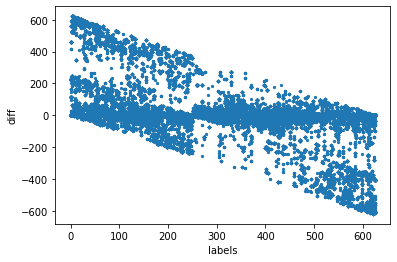

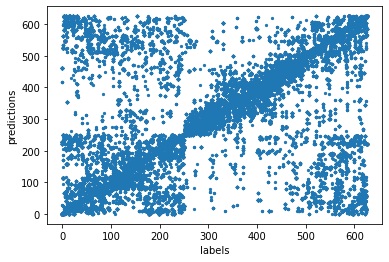

In [ ]:
history.append([avg_valid_loss, avg_valid_acc])

print("Validation: Loss: {:.4f}, Accuracy: {:.4f}%".format(
    avg_valid_loss, avg_valid_acc*100
))
# print("Validation: MSE: {:.4f}".format( ))

diff = predictions_all - labels_all
conc_all = torch.cat((labels_all,predictions_all,diff),dim=0)

plt.scatter(labels_all.cpu(),diff.cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels')
plt.ylabel('diff')
# plt.ylim(0, 1)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()

plt.scatter(labels_all.cpu(),predictions_all.cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels')
plt.ylabel('predictions')
# plt.ylim(0, 1)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()

测试组：用未训练的 0104-2组 进行测试
-

Validation: valid_data_size: 1060.0000
Validation: Loss: 931.1962, Accuracy: 0.0000%


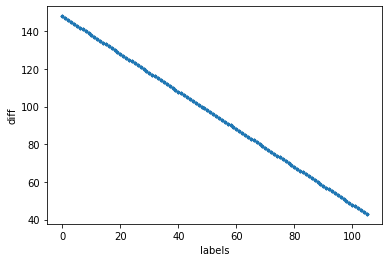

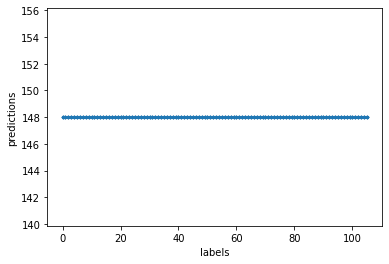

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
image_transforms  = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees = 45),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# dataset = 'E:\gmd_data\microsphere2_dataAugmented'
dataset = 'E:\gmd_data\GMD_0104_2_DATA' # 测试集 0104-2
# dataset = 'E:\gmd_data\GMD_0104_3_DATA' # 测试集 0104-3
# dataset = 'E:\gmd_data\\fangdai_MixTest' # 防呆测试 0104-2-3混合
# dataset = 'E:\gmd_data\GMD_0104_2_DATA_TEST' # 测试集 0104-2 50-8650 照明测试

# train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

batch_size = 32
# num_classes = 173
# class Datset():
#     def __getitem(self,index):
        
#         return image_torch
#     def __len__(self):
#         pass

# data = {
#     # 'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
#     'valid':Datset(root=valid_directory, transform=image_transforms['valid'])

# }
data = {
    # 'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])

}



# train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

# train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)

print("Validation: valid_data_size: {:.4f}".format(
    valid_data_size
))


# 导入模型 将验证集和真值对比图画出来
dataset = 'E:\gmd_data\microsphere2_dataAugmented'
model38 = torch.load( dataset+'/models/'+'model_38.pt')
for param in model38.parameters():
    param.requires_grad = False
model38 = model38.to('cuda:0')
loss_function = nn.NLLLoss()



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
history = []
best_acc = 0.0
best_epoch = 0


valid_loss = 0.0
valid_acc = 0.0

predictions_all = torch.tensor([]).to(device)
labels_all = torch.tensor([]).to(device)

with torch.no_grad():
    model38.eval()
    for j, (inputs, labels) in enumerate(valid_data):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model38(inputs)

        loss = loss_function(outputs, labels)
        # print("valid_data_j: {}".format(j))
        # print("Outputs : ")
        # print(outputs)
        # print("labels ：")
        # print(labels)
        # print("loss ：")
        # print(loss)

        valid_loss += loss.item() * inputs.size(0)

        ret, predictions = torch.max(outputs.data, 1)

        predictions_all = torch.cat((predictions_all,predictions),dim=0)
        labels_all = torch.cat((labels_all,labels),dim=0)

        correct_counts = predictions.eq(labels.data.view_as(predictions))

        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        valid_acc += acc.item() * inputs.size(0)

avg_valid_loss = valid_loss/valid_data_size
avg_valid_acc = valid_acc/valid_data_size

avg_valid_loss = valid_loss/valid_data_size
avg_valid_acc = valid_acc/valid_data_size

# plot
history.append([avg_valid_loss, avg_valid_acc])

print("Validation: Loss: {:.4f}, Accuracy: {:.4f}%".format(
    avg_valid_loss, avg_valid_acc*100
))
# print("Validation: MSE: {:.4f}".format( ))

diff = predictions_all - labels_all
conc_all = torch.cat((labels_all,predictions_all,diff),dim=0)

plt.scatter(labels_all[0:50000].cpu(),diff[0:50000].cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels')
plt.ylabel('diff')
# plt.ylim(0, 1)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()

plt.scatter(labels_all.cpu(),predictions_all.cpu(),s=5)
# plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('labels')
plt.ylabel('predictions')
# plt.ylim(0, 1)
# plt.savefig("C:\\Users\\nanolab115\Desktop\\"+"diff1.png")
plt.show()

Test Command
------


In [ ]:
value,num = torch.max(outputs, 1)
print("num:",num,"value:",value)


num: tensor([168], device='cuda:0') value: tensor([-0.0022], device='cuda:0')


In [ ]:
print("outputs:",outputs)

outputs1 = torch.cat((outputs,outputs),dim=0)
print("outputs1:",outputs1)

value,num = torch.max(outputs1, 1)
print("num:",num,"value:",value)


outputs: tensor([[-4.9504e+01, -5.5556e+01, -6.4833e+01, -7.4970e+01, -8.5962e+01,
         -8.8016e+01, -9.6433e+01, -1.0100e+02, -9.9389e+01, -1.0482e+02,
         -1.0389e+02, -4.7640e+01, -8.3659e+01, -7.6490e+01, -6.6539e+01,
         -6.6105e+01, -6.2998e+01, -6.6530e+01, -6.1330e+01, -5.6204e+01,
         -3.3516e+01, -3.4015e+01, -2.9832e+01, -5.1219e+01, -5.1118e+01,
         -7.7792e+01, -8.0729e+01, -8.7210e+01, -7.7605e+01, -1.0523e+02,
         -9.8735e+01, -1.0985e+02, -1.2003e+02, -4.8393e+01, -1.2292e+02,
         -1.2874e+02, -1.2656e+02, -1.1117e+02, -1.1285e+02, -1.0200e+02,
         -9.0714e+01, -8.9426e+01, -7.5569e+01, -6.9013e+01, -4.4566e+01,
         -5.4173e+01, -5.0531e+01, -4.3763e+01, -4.0917e+01, -4.7471e+01,
         -4.0777e+01, -4.0884e+01, -4.5677e+01, -6.0832e+01, -6.6128e+01,
         -3.3768e+01, -6.3326e+01, -8.3918e+01, -8.3963e+01, -7.3704e+01,
         -1.0347e+02, -9.3055e+01, -1.0524e+02, -1.1130e+02, -1.0509e+02,
         -1.0142e+02, -6.6610

In [ ]:
num2 = torch.tensor([]).to(device)
num1 = torch.cat((num2,num),dim=0)

In [ ]:
print('C:\\Users\\nanolab115\Desktop\\'+'diff1.png')

C:\Users\nanolab115\Desktop\diff1.png
